<a href="https://colab.research.google.com/github/Melo95/ML_course_Pavia_23/blob/v2/neural-networks/4.JetTaggingConv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Jet Tagging with **CNN 1D** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a network based on Conv1D  layers.

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet sequence, i.e. a list of particles. Foe each particle, the four-momentum coordinates are given as features.
For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf and https://arxiv.org/pdf/1908.05318.pdf.

For details on the dataset, see Notebook1

---

In [3]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

nb, if you are running locally you can skip the step below and change the paths later to point to the folder with your previous download of the datasets.

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [4]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  17.8M      0 --:--:--  0:00:18 --:--:-- 23.3M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
inputDir = "Data-MLtutorial/JetDataset/"

In [6]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for i, fileIN in enumerate(datafiles):
    f = h5py.File(fileIN)
    if i == 0: print(f.get("particleFeatureNames")[:])
    print("Appending %s" %fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


The dataset consists of 50000 with up to 100 particles in each jet.  For each particle, 16 features are given (see printout)

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


We interpret the last index (the particle feature) as the channel

# Building the Conv1D model

A Conv1D model is a special case of convolutional NN where the kernel is convolved with the input tensor over a single spatial (or temporal) dimension with some ordering. Only the number of "time steps" or elements of the sequence to be processed by each filter stride is specified, i.e. one specifies only one dimension of the kernel. The other dimension of the kernel is equal to the number of channels.

In the jet tagging model below we are analyzing a sequence of particles in within the jet which are ordered by momentum (from the highest to the lowest). Note that this is not the only order possible.

The drawing below illustrate the Conv1D processing concept. In this example, starting from 10 particles with 1 feature we are processing 4 particles per each stride of each of the four 4x1 kernels to create 4 new filtered sequences of 7 elements. A final pooling layer is applied to each of the filtered sequences to output the final feature vector that can be used as an input to a regular fully connected layer.


<div>
<img src="https://raw.githubusercontent.com/jngadiub/ML_course_Pavia_23/main/neural-networks/conv1d.png" width="400"/>
</div>

In [8]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, AveragePooling1D, Dropout, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [9]:
featureArrayLength = (X_train.shape[1],X_train.shape[2]) #how many particles and how many sequences
dropoutRate = 0.25

In [10]:
####
inputList = Input(shape=(featureArrayLength))
x = Conv1D(20, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList) #20 filters
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(40, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(60, kernel_size=2, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=9)(x)
#
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 conv1d (Conv1D)             (None, 98, 20)            980       
                                                                 
 average_pooling1d (AverageP  (None, 32, 20)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 40)            2440      
                                                                 
 average_pooling1d_1 (Averag  (None, 10, 40)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 60)             4860  

We now train the model

In [12]:
batch_size = 128
n_epochs = 200

In [13]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 15s - loss: 1.5165 - val_loss: 1.4358 - lr: 0.0010 - 15s/epoch - 58ms/step
Epoch 2/200
262/262 - 1s - loss: 1.4023 - val_loss: 1.3228 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 3/200
262/262 - 1s - loss: 1.3482 - val_loss: 1.2835 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4/200
262/262 - 1s - loss: 1.3214 - val_loss: 1.2624 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 5/200
262/262 - 2s - loss: 1.3012 - val_loss: 1.2547 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/200
262/262 - 2s - loss: 1.2867 - val_loss: 1.2267 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 7/200
262/262 - 2s - loss: 1.2728 - val_loss: 1.2151 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 8/200
262/262 - 1s - loss: 1.2576 - val_loss: 1.2018 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 9/200
262/262 - 1s - loss: 1.2340 - val_loss: 1.1541 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 10/200
262/262 - 1s - loss: 1.2022 - val_loss: 1.1240 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 11/200
262/262 - 1s - loss: 1.1523 - val_loss: 1.0

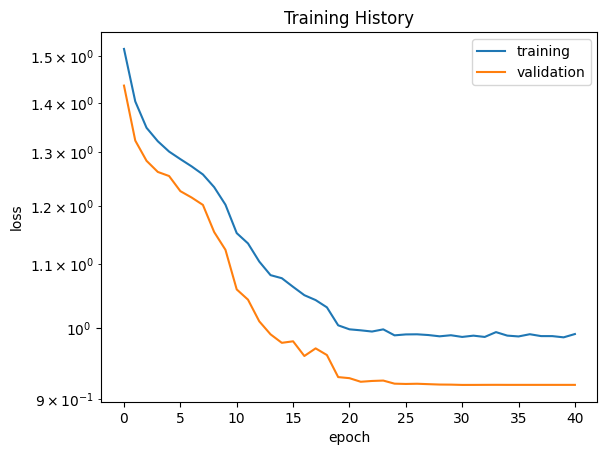

In [14]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [15]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 1s 2ms/step


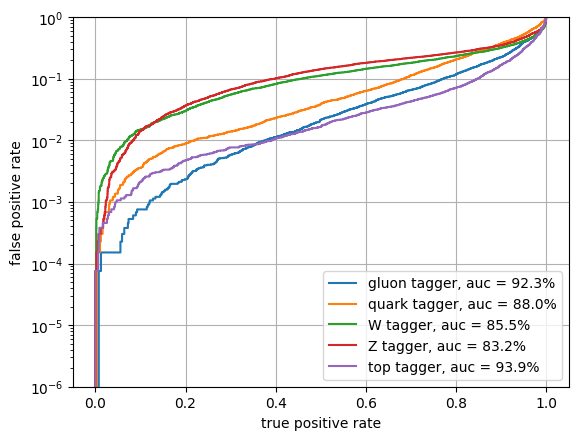

In [16]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("true positive rate")
plt.ylabel("false positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()